In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [56]:
df_all = pd.read_csv('../Output/Submission/features/features_all.csv')
df_all = df_all[df_all['ContourType'] == 'Manual']
# drop min and max
df_all = df_all[~df_all['Feature'].isin(['firstorder_Minimum', 'firstorder_Maximum'])]
df_result = pd.DataFrame()

patIDs = df_all['PatID'].unique()
fts = df_all['Feature'].unique()


In [57]:
from scipy.stats import wilcoxon, ttest_rel

def compare_fractions(df_ft, frac1, frac2):
    '''
    Computes wilcoxon rank sum test for two fractions and t-test rel    
    '''
    ft_vals1 = df_ft[df_ft['Fraction'] == frac1]['FeatureValue'].values
    ft_vals2 = df_ft[df_ft['Fraction'] == frac2]['FeatureValue'].values

    # Wilcoxon rank sum test
    w, p_w = wilcoxon(ft_vals1, ft_vals2)

    # t-test
    t, p_t = ttest_rel(ft_vals1, ft_vals2)

    return w, p_w, t, p_t


In [78]:
# loop through features and do statistical comparison
from scipy.stats import wilcoxon, ttest_rel

fractions = df_all['Fraction'].unique()

df_comp = pd.DataFrame(columns=['Feature', 'FracA', 'FracB', 'Wilcoxon', 'p_w', 't', 'p_t'])

for ft in fts:
    df_ft = df_all[df_all['Feature'] == ft]

    # compare every fraction to fraction 1
    for i in range(int(len(fractions))):
        fracA = fractions[i]
        for j in range(i+1, len(fractions)):
            fracB = fractions[j]
            w, p_w, t, p_t = compare_fractions(df_ft, fracA, fracB)
            df_comp = df_comp.append({'Feature': ft, 'Comparison':f'{fracA}-{fracB}', 'FracA': fracA, 'FracB': fracB, 'Wilcoxon': w, 'p_w': p_w, 't': t, 'p_t': p_t}, ignore_index=True)

        
    
df_comp_sign = df_comp[df_comp['p_w'] <= 0.05]
df_comp_sign = df_comp_sign[['Feature', 'Comparison', 'Wilcoxon', 'p_w']]


print(df_comp_sign.shape)

c:\Users\b01297ar\Documents\ProstateMRL-local\ProstateMRL-Radiomics\envPR\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\Users\b01297ar\Documents\ProstateMRL-local\ProstateMRL-Radiomics\envPR\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\Users\b01297ar\Documents\ProstateMRL-local\ProstateMRL-Radiomics\envPR\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\Users\b01297ar\Documents\ProstateMRL-local\ProstateMRL-Radiomics\envPR\lib\site-packages\sc

(558, 4)


<AxesSubplot:xlabel='Feature', ylabel='Comparison'>

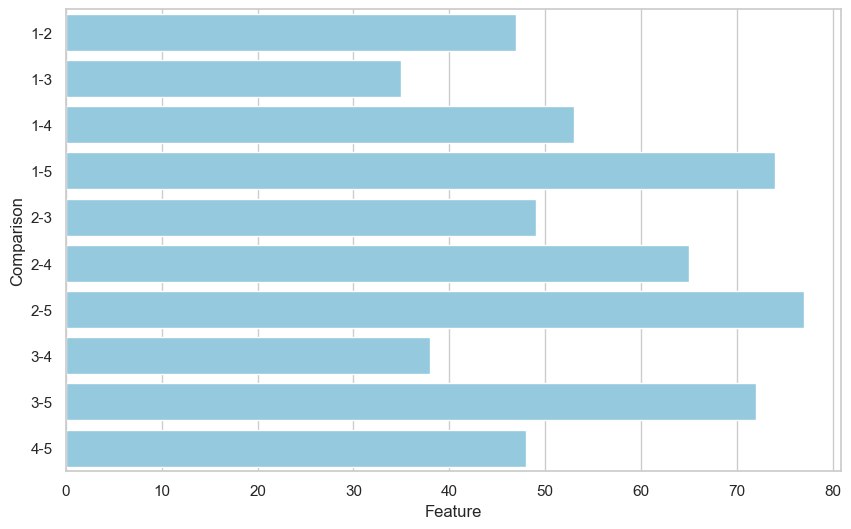

In [85]:
# bar chart counts of significant differences
df_bar_comp = df_comp_sign.groupby('Comparison').count().reset_index()

df_bar_comp = df_bar_comp[['Comparison', 'Feature']]


# horiziozntal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='Comparison', data=df_bar_comp, color='skyblue')




In [97]:
def get_mean_difference(df_ft, frac1, frac2):
    '''
    Computes mean difference between two fractions
    '''
    ft_vals1 = df_ft[df_ft['Fraction'] == frac1]['FeatureValue'].values
    ft_vals2 = df_ft[df_ft['Fraction'] == frac2]['FeatureValue'].values

    # mean difference
    mean_diff = np.mean(abs(ft_vals1) - abs(ft_vals2))

    return mean_diff


# loop through features and get mean difference
df_diff = pd.DataFrame(columns=['Feature', 'Comparison', 'MeanDiff'])

for ft in fts:
    df_ft = df_all[df_all['Feature'] == ft]

    # compare every fraction to fraction 1
    for i in range(int(len(fractions))):
        fracA = fractions[i]
        for j in range(i+1, len(fractions)):
            fracB = fractions[j]
            mean_diff = get_mean_difference(df_ft, fracA, fracB)
            df_diff = df_diff.append({'Feature': ft, 'Comparison':f'{fracA}-{fracB}', 'MeanDiff': mean_diff}, ignore_index=True)



In [98]:
df_diff_max = pd.DataFrame(columns=['Feature', 'Comparison', 'MeanDiff'])

for ft in fts:
    df_ft = df_all[df_all['Feature'] == ft]

    # get row with max mean difference
    max_diff = df_diff[df_diff['Feature'] == ft]['MeanDiff'].max()
    max_diff_row = df_diff[(df_diff['Feature'] == ft) & (df_diff['MeanDiff'] == max_diff)]

    df_diff_max = df_diff_max.append(max_diff_row, ignore_index=True)

df_diff_max = df_diff_max.sort_values(by='MeanDiff', ascending=False)


<AxesSubplot:xlabel='Feature', ylabel='Comparison'>

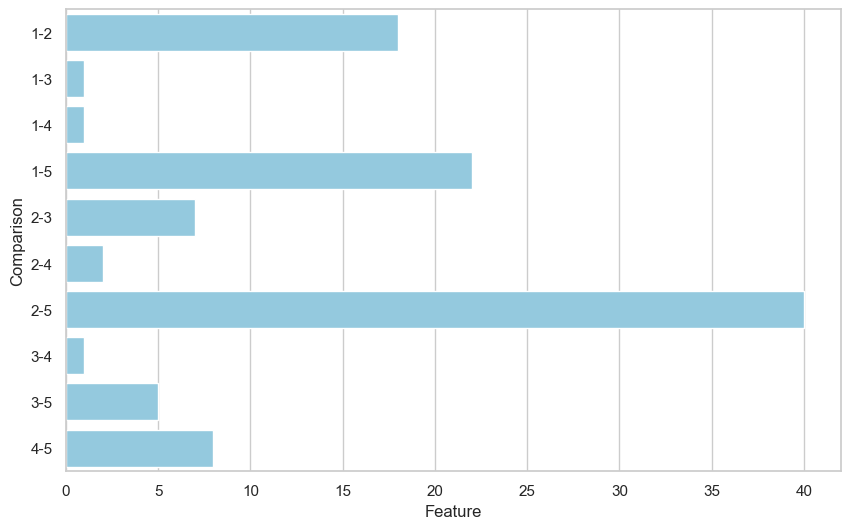

In [99]:
# do a bar chart of the count of max differences per comparison
df_bar_mean_diff = df_diff_max.groupby('Comparison').count().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='Comparison', data=df_bar_mean_diff, color='skyblue')

